## About
`NASNet` refers to Neural Architecture Search Network, a family of models that were designed automatically by learning the model architectures directly on the dataset of interest. This architecture was able to achieve `82.7% accuracy on ImageNet 2012 Dataset`. The model developed by this program will be used to find the best food classification model for our project [SeeFood](https://https://github.com/aditya-taparia/seefood). This model will be trained on `food101 tensorflow dataset` with batch size of 32. For better results we will also be using model pretrained on ImageNet dataset and then fine-tuning that as per our dataset.

*   **Paper Link :** https://arxiv.org/abs/1707.07012
*   **Food101 Dataset :** https://www.tensorflow.org/datasets/catalog/food101

# Data preprocessing

## Loading Dataset
Getting test and train dataset and label information from the tensorflow dataset - food101.

In [1]:
# Importing Packages
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import cv2
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.nasnet import NASNetMobile
from tensorflow.keras.applications.nasnet import preprocess_input
from keras.callbacks import ModelCheckpoint

In [ ]:
# Adding drive to colab
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Getting train and test data from food101 dataset
(train, test), ds_info = tfds.load(
    'food101',
    split=['train[:70%]', 'train[70%:]'], 
    with_info=True, 
    as_supervised=True
)

## Normalizing Image and Processing Dataset

In [4]:
# Defining some useful variables
batch_size = 32
num_train = sum(1 for _ in train)
num_validation = sum(1 for _ in test)
num_classes = len(ds_info.features['label'].names)
num_iterations = int(num_train/batch_size)
num_validate = num_validation // batch_size

# Normalizing Image
def normalize_img(image, label, img_size):
    # Resize image to the desired img_size and normalize it
    # One hot encode the label
    image = tf.image.resize(image, img_size)
    image = tf.cast(image, tf.float32) / 255.
    label = tf.one_hot(label, depth=num_classes)
    return image, label

# Processing Training and Validation Dataset
def preprocess_data(train, validation, batch_size, img_size):
    # Apply the normalize_img function on all train and validation data and create batches
    train_processed = train.map(lambda image, label: normalize_img(image, label, img_size))
    train_processed = train_processed.batch(batch_size).repeat()

    validation_processed = validation.map(lambda image, label: normalize_img(image, label, img_size))
    validation_processed = validation_processed.batch(batch_size)

    return train_processed, validation_processed

# Run preprocessing
train_processed_224, validation_processed_224 = preprocess_data(train, test, batch_size, img_size=[224, 224])

# Creating the base model from the pre-trained convnets
We will create the base model from the NASNetMobile model provided by Tensorflow. This is pre-trained on the ImageNet dataset, a large dataset consisting of 1.4M images and 1000 classes. ImageNet is a research training dataset with a wide variety of categories which will help us to train model to classify on different food categories.

First we will instantiate a NASNetMobile model pre-loaded with weights trained on ImageNet. By specifying the include_top=False argument, we will load a network that doesn't include the classification layers at the top, which is ideal for `feature extraction`. Then we will freeze the weights of our base_model and add classification layer on top of it.

In [ ]:
# Input image shape
IMG_SHAPE = (224, 224, 3)

# NASNetMobile Model
nasnet_base_model = NASNetMobile(
    input_shape=IMG_SHAPE, 
    weights='imagenet', 
    include_top=False
)

# Freezing all the layers in the NASNet Architecture
nasnet_base_model.trainable = False

# Adding prediction layer for our dataset classes
x = Flatten()(nasnet_base_model.output)
prediction = Dense(num_classes, activation='softmax')(x)

# Declaring model
model = Model(inputs = nasnet_base_model.input, outputs=prediction)

# Defining optimizer and loss function
base_learning_rate = 0.0001
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate), 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

# Declaring checkpoint to save models at every epoch whenever validation accuracy increases
checkpoint = ModelCheckpoint(
    "/content/drive/MyDrive/Colab Notebooks/Machine Learning Project/best_NesNetModel", 
    monitor='val_accuracy', 
    verbose=1,
    save_best_only=True, 
    mode='auto'
)

# Training the model

First we will train the model while freezing the weights of the base model.

In [6]:
initial_epochs = 10

In [ ]:
# Training the model
history = model.fit(
  train_processed_224,
  validation_data = validation_processed_224,
  epochs = initial_epochs,
  steps_per_epoch = num_iterations,
  validation_steps = num_validate,
  callbacks = [checkpoint],
)

## Learning Curve
Learning curves of the training and validation accuracy/loss when using the NASNetMobile base model as a fixed feature extractor.

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

**Output:**

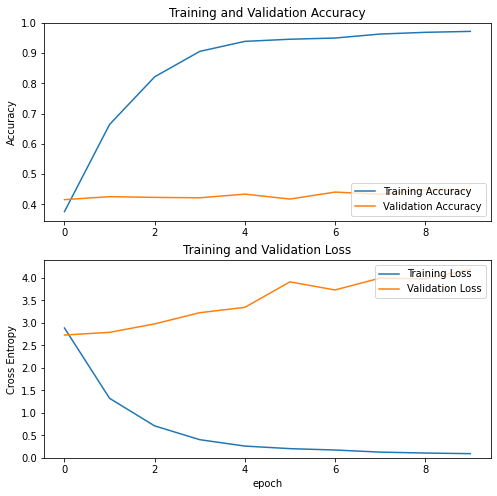

## Fine Tuning
In the feature extraction, we are only training a few layers on top of an NASNetMobile base model. The weights of the pre-trained network were not updated during training.

One way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the pre-trained model alongside the training of the classifier you added. The training process will force the weights to be tuned from generic feature maps to features associated specifically with the dataset.

For fine-tuning we will unfreeze the base_model and set the bottom layers to be un-trainable. Then, we will recompile the model (necessary for these changes to take effect), and resume training. While recompiling we will lower the learning rate so that weights could readapt without overfitting.

In [ ]:
print("Number of layers in the base model: ", len(nasnet_base_model.layers))

In [10]:
# Unfreezing all the layers
nasnet_base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in nasnet_base_model.layers[:fine_tune_at]:
  layer.trainable = False

In [11]:
# Recompiling the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate/10), 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

In [ ]:
# Continuing the model training
fine_tune_epochs = 20
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(
  train_processed_224,
  epochs = total_epochs,
  initial_epoch = history.epoch[-1],
  validation_data = validation_processed_224,
  steps_per_epoch = num_iterations,
  validation_steps = num_validate,
  callbacks = [checkpoint],
)

## Learning Curver II
Now, the learning curves of the training and validation accuracy/loss after fine-tuning the last few layers of the NASNetMobile base model and training the classifier on top of it looks like:

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([min(plt.ylim()), 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, max(plt.ylim())])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

**Output:**

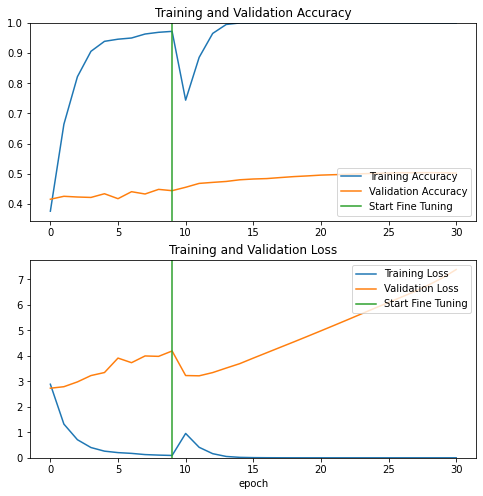

# Saving and Testing Model

In [ ]:
# Saving the model and converting it to tflite format
model.save('NasNetMobileModel')
model_convert = tf.lite.TFLiteConverter.from_saved_model('/content/NasNetMobileModel')
tflite_model = model_convert.convert()

# Save the tflite model
with open('seefood_NasNetMobileModel.tflite', 'wb') as f:
  f.write(tflite_model)

In [ ]:
# Creating a test dataset
val_batches = tf.data.experimental.cardinality(validation_processed_224)
test_dataset = validation_processed_224.take(val_batches // 5) # May be same as 'num_validation'

# Evaluating its accuracy
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

In [ ]:
# Checking the prediction on some random images from google

# Apple Pie Image
pred_img1 =r'/content/apple pie.jfif'
img1 = cv2.imread(pred_img1)
img1 = img1/255 # rescale the image
img1 = cv2.resize(img1, (224,224)) # resize to same size used in training
img1 = np.expand_dims(img1, axis=0)
pred1 = model.predict(img1)
index1 = np.argmax(pred1) # this will be the index of the class predicted
class_name1 = ds_info.features['label'].names[index1] # this will be the name of the class predicted

# Chocolate Cake Image
pred_img2 =r'/content/chocolate cake.jfif'
img2 = cv2.imread(pred_img2)
img2 = img2/255 # rescale the image
img2 = cv2.resize(img2, (224,224)) # resize to same size used in training
img2 = np.expand_dims(img2, axis=0)
pred2 = model.predict(img2)
index2 = np.argmax(pred2) # this will be the index of the class predicted
class_name2 = ds_info.features['label'].names[index2] # this will be the name of the class predicted

# Spagetti Image
pred_img3 =r'/content/spagetti.jpg'
img3 = cv2.imread(pred_img3)
img3 = img3/255 # rescale the image
img3 = cv2.resize(img3, (224,224)) # resize to same size used in training
img3 = np.expand_dims(img3, axis=0)
pred3 = model.predict(img3)
index3 = np.argmax(pred3) # this will be the index of the class predicted
class_name3 = ds_info.features['label'].names[index3] # this will be the name of the class predicted

# Displaying the output
plt.figure(figsize=(10, 10))
# Image - 1
plt.subplot(1, 3, 1)
plt.imshow(plt.imread(pred_img1))
plt.title(class_name1)
plt.axis("off")
# Image - 2
plt.subplot(1, 3, 2)
plt.imshow(plt.imread(pred_img2))
plt.title(class_name2)
plt.axis("off")
# Image - 3
plt.subplot(1, 3, 3)
plt.imshow(plt.imread(pred_img3))
plt.title(class_name3)
plt.axis("off")
plt.tight_layout(4)
plt.show()

**Output:**


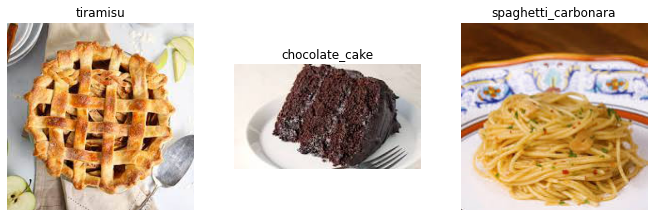

# Summary
* This model gave around 99.99% accuracy on training dataset and around 50% accuracy on test dataset.
* We are using a pre-trained model for feature extraction. We are doing so because the dataset we have is very limited and it is a common practice to take advantage of features learned by a model trained on a larger dataset in the same domain(image classification). 
* To further improve performance we are repurposing the top-level layers of the pre-trained models to the new dataset via fine-tuning. By doing so we have tuned the weights such that our model learned high-level features specific to the dataset.
* We have also tested this model with some random images from google and it was able to predict 2/3 images perfectly.